In [1]:
num_epoch = 500      
learning_rate = 0.002
batch_size = 2000

hidden_size = 64 #number of features in hidden state
num_layers = 2  #number of stacked lstm layers
bidirectional = True
drop_out = 0.5
bidirectional_forward_backward = 2 if bidirectional else 1

input_size = 41 #number of features
num_classes_attack_cat = 11 #number of output classes 
num_classes_label = 2       #number of output classes 

hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(["label"], axis=1, inplace=True)

        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        print(df_all_rows.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df_all_rows['attack_cat'].value_counts())

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(["attack_cat"], axis=1, inplace=True)

        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)        
        cols = ['proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        print(df_all_rows.label.value_counts().sort_values().plot(kind = "pie"))
        print(df_all_rows['label'].value_counts())

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

AxesSubplot(0.125,0.125;0.775x0.755)
6.0     93000
5.0     58871
3.0     44525
10.0    25000
4.0     24246
2.0     16353
7.0     13987
0.0      2677
1.0      2329
8.0      1511
9.0       174
Name: attack_cat, dtype: int64


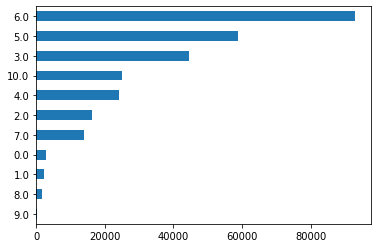

In [5]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv",
                                                 "/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

AxesSubplot(0.260833,0.125;0.503333x0.755)
1.0    189673
0.0     93000
Name: label, dtype: int64


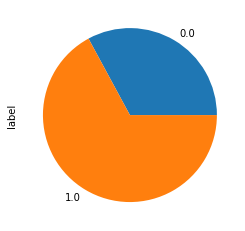

In [6]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv",
                                                           "/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

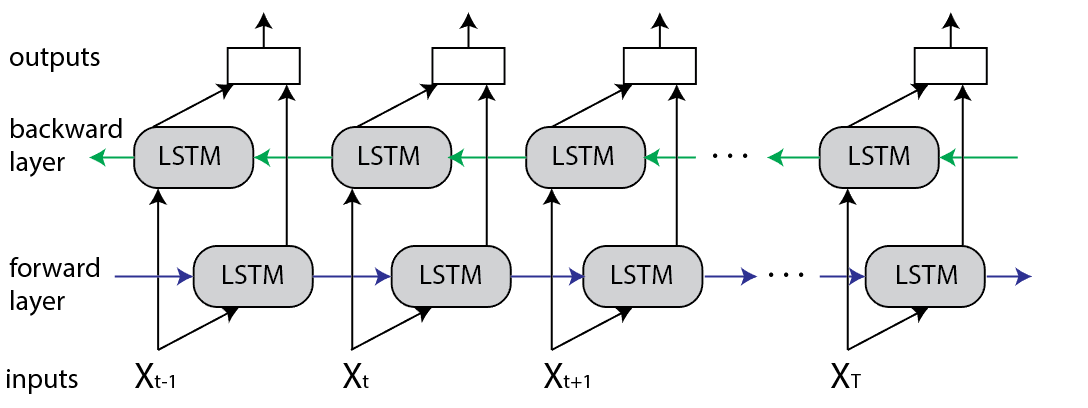

In [7]:
class LSTM_Model_attack(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_attack, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc_layers = nn.Sequential(
        nn.Linear(hidden_size * bidirectional_forward_backward, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.ReLU(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, num_classes)
        )
    
    def forward(self,x):
                                                # 2 => forward and backward for bidirectional
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc_layers(out[:, -1, :]) 
        return out


class LSTM_Model_label(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_label, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc_layers = nn.Sequential(
        nn.Linear(hidden_size * bidirectional_forward_backward, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.ReLU(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, num_classes)
        )
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc_layers(out[:, -1, :]) 
        return out


In [8]:
my_model_attack = LSTM_Model_attack(num_classes_attack_cat, input_size, hidden_size, num_layers).to(device=device)
my_model_attack

LSTM_Model_attack(
  (lstm): LSTM(41, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=11, bias=True)
  )
)

In [9]:
my_model_attack.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0470,  0.1197, -0.0224,  ..., -0.0563,  0.0538, -0.0786],
                      [-0.0922,  0.0282, -0.0881,  ..., -0.0572,  0.0472,  0.1115],
                      [-0.0873, -0.1179, -0.0999,  ...,  0.1012, -0.0618,  0.0132],
                      ...,
                      [-0.0709, -0.0257, -0.0326,  ..., -0.0806,  0.1027, -0.0812],
                      [-0.1174, -0.0408,  0.1011,  ...,  0.1176, -0.0158, -0.0916],
                      [-0.0216,  0.0564,  0.0031,  ..., -0.0958, -0.0724, -0.0973]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[-0.0867, -0.0534, -0.0193,  ...,  0.0990,  0.0340,  0.0113],
                      [ 0.1004, -0.0073,  0.0538,  ...,  0.0829, -0.1120, -0.0037],
                      [-0.0427, -0.0329, -0.0174,  ..., -0.0698,  0.0431,  0.0276],
                      ...,
                      [ 0.0266,  0.0292,  0.0697,  ...,  0.0770, -0.1161, -0.02

In [10]:
my_model_label = LSTM_Model_label(num_classes_label, input_size, hidden_size, num_layers).to(device=device)
my_model_label

LSTM_Model_label(
  (lstm): LSTM(41, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

# **optimizer and loss function**

In [11]:
loss_fn1 = nn.CrossEntropyLoss().to(device=device)
loss_fn2 = nn.CrossEntropyLoss().to(device=device)
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=learning_rate)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=learning_rate)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

Epoch: 0, loss: 1.0650
Epoch: 50, loss: 0.4413
Epoch: 100, loss: 0.4014
Epoch: 150, loss: 0.4065
Epoch: 200, loss: 0.3677
Epoch: 250, loss: 0.3845
Epoch: 300, loss: 0.3844
Epoch: 350, loss: 0.3663
Epoch: 400, loss: 0.3411
Epoch: 450, loss: 0.3954
Epoch: 500, loss: 0.3555
Execution Time : 1226791.5000


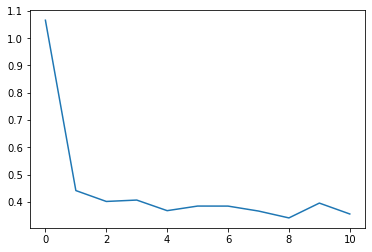

In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x) , batch_y)
        loss1.backward() 
        optimizer1.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss1.item())) 
         loss_plot.append(loss1.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test attack cat**

In [14]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)

    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)

print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

acc : 83.87%


Confusion matrix, without normalization
[[ 7584     0     0     0     0     0     0     0     0     0     0]
 [    0     7     0     1     0     0     3    41     0     0     0]
 [    0     0   226    28    37    13    32   100    17     0     0]
 [    0     0     8  3293    33     3    14   822   113     3     0]
 [    0     1    35    33 25859     6  1462   251    16     0    12]
 [    0     1    13     3    17 17348    14   241    35     2     0]
 [    0     1    30    29  2225    12  4247   687    88     2     2]
 [    0     2    40   281   251    65   333 11716   683    12     0]
 [    0     0    44    36    59    28   120  3856   753    16     1]
 [    0     0     5     3     2     3   104   441    75    56     0]
 [    0     0     0     0   117     0    98   449    66     0    36]]


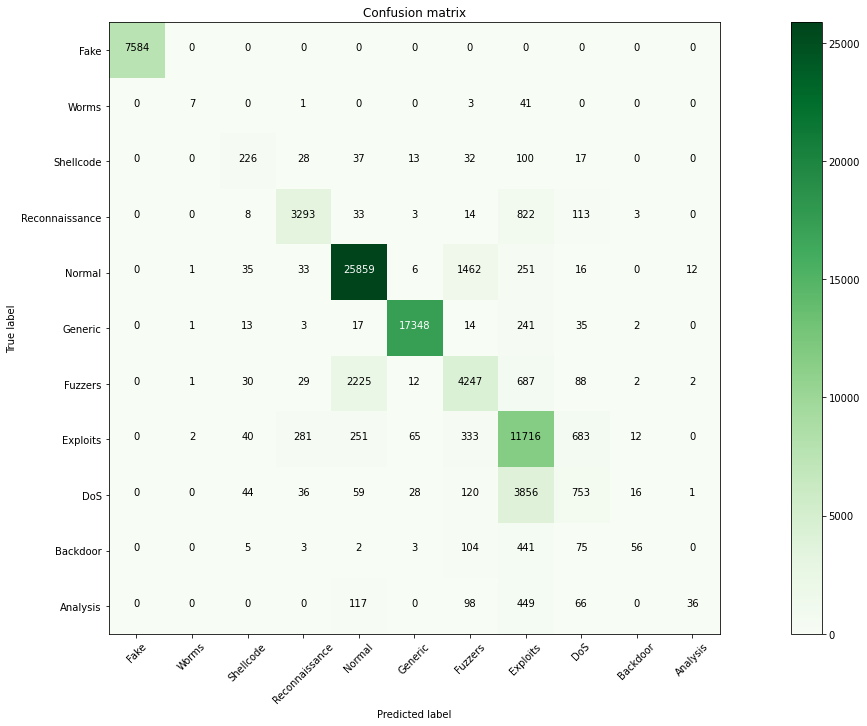

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[10,9,8,7,6,5,4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['Fake','Worms','Shellcode','Reconnaissance','Normal','Generic','Fuzzers','Exploits','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [16]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.71      0.05      0.09       766
           1       0.62      0.08      0.14       689
           2       0.41      0.15      0.22      4913
           3       0.63      0.88      0.73     13383
           4       0.66      0.58      0.62      7323
           5       0.99      0.98      0.99     17674
           6       0.90      0.93      0.92     27675
           7       0.89      0.77      0.82      4289
           8       0.56      0.50      0.53       453
           9       0.58      0.13      0.22        52
          10       1.00      1.00      1.00      7584

    accuracy                           0.84     84801
   macro avg       0.72      0.55      0.57     84801
weighted avg       0.83      0.84      0.82     84801



# **train label**

Epoch: 0, loss: 0.1866
Epoch: 50, loss: 0.1168
Epoch: 100, loss: 0.1265
Epoch: 150, loss: 0.1051
Epoch: 200, loss: 0.1117
Epoch: 250, loss: 0.1006
Epoch: 300, loss: 0.1017
Epoch: 350, loss: 0.0965
Epoch: 400, loss: 0.1013
Epoch: 450, loss: 0.0917
Epoch: 500, loss: 0.0970
Execution Time : 1246376.8750


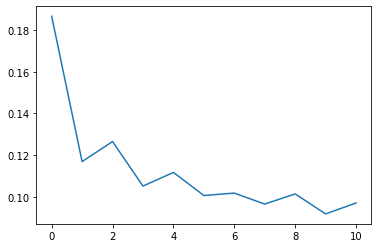

In [17]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_label_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer2.zero_grad()
        loss2 = loss_fn2(my_model_label(batch_x) , batch_y)
        loss2.backward() 
        optimizer2.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss2.item())) 
         loss_plot.append(loss2.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test label**

In [18]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_label_dataloader:

    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)

    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i) 
        
print("acc : %.2f" % (100.*correct / len(test_label)),end="")
print("%")

acc : 94.46%


Confusion matrix, without normalization
[[54181  2659]
 [ 2039 25922]]


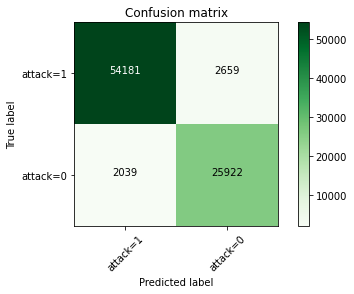

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')

In [20]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     27961
           1       0.96      0.95      0.96     56840

    accuracy                           0.94     84801
   macro avg       0.94      0.94      0.94     84801
weighted avg       0.95      0.94      0.94     84801

